In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
import os.path
import sklearn.neural_network
import sklearn.svm
import sklearn.naive_bayes
import sklearn.tree
import lime.lime_tabular_mod
import lime.lime_tabular_multiregressor
import lime.lime_tabular_multiclassifier
import lime.lime_tabular_singleclassifier
import matplotlib.pyplot as plt
import doc.mod.utils.DatasetRepository as dr
import doc.mod.utils.ResultsProcessing as rp
from tqdm import tqdm

repo = dr.DatasetRepository("../data")


pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})





# Dataset: Heart Disease

In [2]:
labels_count = 2
bins_count = 30
version_str = "v3"
dataset_name = "HeartDisease"
dataset = repo.get_heart_disease_dataset(random_state=42)
dataset.train_data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
80,41,1,2,112,250,0,1,179,0,0.0,2,0,2
295,63,1,0,140,187,0,0,144,1,4.0,2,2,3
255,45,1,0,142,309,0,0,147,1,0.0,1,3,3
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2
125,34,0,1,118,210,0,1,192,0,0.7,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,64,1,0,128,263,0,1,105,1,0.2,1,1,3
170,56,1,2,130,256,1,0,142,1,0.6,1,1,1
63,41,1,1,135,203,0,1,132,0,0.0,1,0,1
135,49,0,0,130,269,0,1,163,0,0.0,2,0,2







## Train different classifiers on the selected dataset (with their default settings)

In [3]:
models = [
    ("Random Forest", sklearn.ensemble.RandomForestClassifier(n_jobs=-1)),
    ("AdaBoost", sklearn.ensemble.AdaBoostClassifier()),
    ("DecisionTree", sklearn.tree.DecisionTreeClassifier()),
    ("Neural Network", sklearn.neural_network.MLPClassifier()),
    # ("SVM", sklearn.svm.LinearSVC()), do not provide predict_proba
    ("Naive Bayes", sklearn.naive_bayes.GaussianNB()),
    ("kNN", sklearn.neighbors.KNeighborsClassifier())
]
precision_for_classifier = {}
recall_for_classifier = {}
f1_for_classifier = {}
for (classifier_name, model) in models:
    x = dataset.train_data.to_numpy()
    y = dataset.train_labels.to_numpy()
    model.fit(x, y)

    x = dataset.test_data.to_numpy()
    y_true = dataset.test_labels.to_numpy()
    y_predicted = model.predict(x)

    precision_for_classifier[classifier_name] = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_predicted, average="macro")
    recall_for_classifier[classifier_name] = sklearn.metrics.recall_score(y_true=y_true, y_pred=y_predicted, average="macro")
    f1_for_classifier[classifier_name] = sklearn.metrics.f1_score(y_true=y_true, y_pred=y_predicted, average="macro")

test_data_subset = dataset.test_data.to_numpy()

test_instances_count = test_data_subset.shape[0]


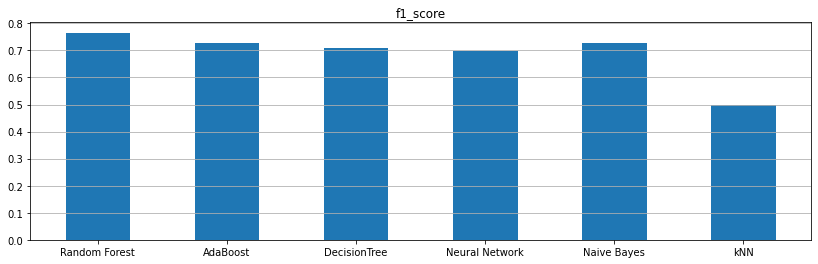

In [4]:
plt.figure(figsize=(14,4))
plt.bar(f1_for_classifier.keys(), f1_for_classifier.values(), width=0.5)
plt.title("f1_score")
plt.grid(axis="y")
plt.show()





## Use original LIME to explain classifiers' predictions

In [5]:
results_file_default = f"saved_results/{dataset_name}/default_results_{version_str}"
if os.path.isfile(results_file_default + ".npy"):
    postprocessor_default = rp.ResultsProcessing.from_file(
        results_file_default,
        models,
        labels_count
    )

else:
    scores_for_surrogate_model_default = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    losses_for_surrogate_model_default = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    losses_mean_for_cv_model_default = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    losses_std_for_cv_model_default = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    fidelity_loss_on_explanation_default = \
        np.empty(shape=(len(models), test_instances_count,), dtype="float32")
    fidelity_loss_on_generated_data_default = \
        np.empty(shape=(len(models), test_instances_count,), dtype="float32")
    fidelity_loss_distribution_quantiles_default = \
        np.empty(shape=(len(models), test_instances_count, bins_count), dtype="float32")

    for model_idx, (classifier_name, model) in enumerate(models):

        explainer_default = lime.lime_tabular_mod.LimeTabularExplainerMod(
            dataset.train_data.to_numpy(),
            feature_names = dataset.train_data.columns.to_list(),
            class_names = model.classes_,
            discretize_continuous=False,
            sample_around_instance=True,
            categorical_features=dataset.categorical_features,
            with_kfold=5
        )

        for instance_idx, test_instance in enumerate(tqdm(
                    test_data_subset,
                    desc=f"{classifier_name}",
                    bar_format="{desc:<20}{percentage:3.0f}%|{bar}{r_bar}"
        )):

            explanation = explainer_default.explain_instance(
                test_instance.reshape(-1),
                model.predict_proba,
                num_features = 4,
                top_labels = labels_count,
                distance_metric="minkowski",
                minkowski_norm=100.
            )
            scores_for_surrogate_model_default[model_idx, instance_idx, :] = \
                explanation.get_scores_for_surrogate_model()
            losses_for_surrogate_model_default[model_idx, instance_idx, :] = \
                explanation.get_losses_for_surrogate_model()
            losses_mean_for_cv_model_default[model_idx, instance_idx, :] = \
                explanation.get_losses_for_cv_model(out="mean")
            losses_std_for_cv_model_default[model_idx, instance_idx, :] = \
                explanation.get_losses_for_cv_model(out="std")
            fidelity_loss_on_explanation_default[model_idx, instance_idx] = \
                explanation.get_fidelity_loss_on_explanation()
            fidelity_loss_on_generated_data_default[model_idx, instance_idx] = \
                explanation.get_fidelity_loss_on_generated_data()
            fidelity_loss_distribution_quantiles_default[model_idx, instance_idx, :] = \
                explanation.get_fidelity_loss_distribution(quantiles=bins_count)

    postprocessor_default = rp.ResultsProcessing(
        models,
        labels_count,
        scores_for_surrogate_model_default,
        losses_for_surrogate_model_default,
        losses_mean_for_cv_model_default,
        losses_std_for_cv_model_default,
        fidelity_loss_on_explanation_default,
        fidelity_loss_on_generated_data_default,
        fidelity_loss_distribution_quantiles_default
    )
    postprocessor_default.save_results(results_file_default)

kNN                 100%|██████████| 31/31 [00:26<00:00,  1.18it/s]


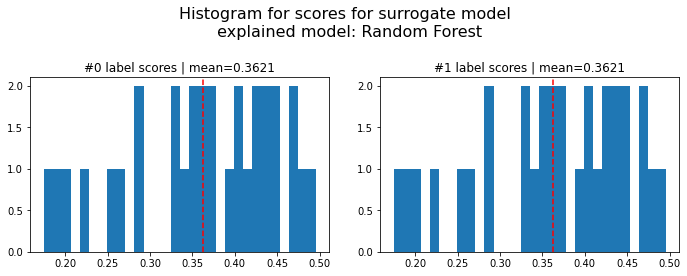

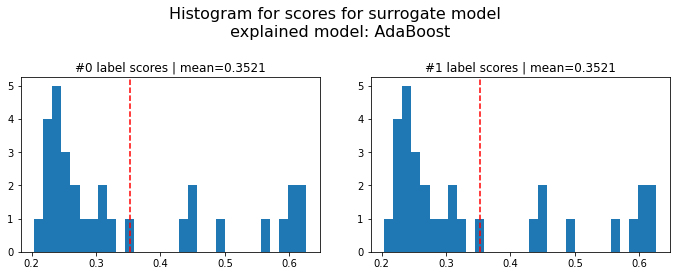

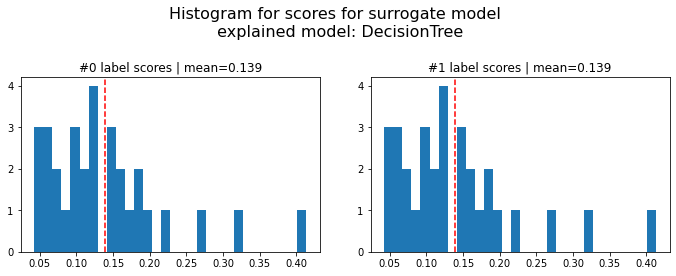

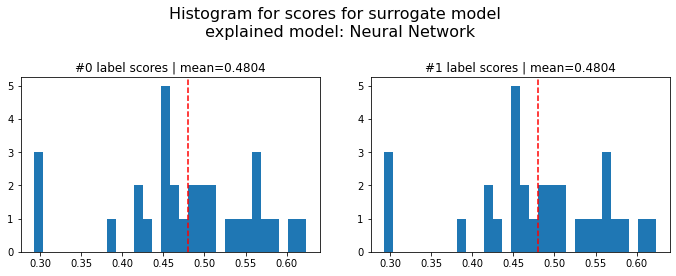

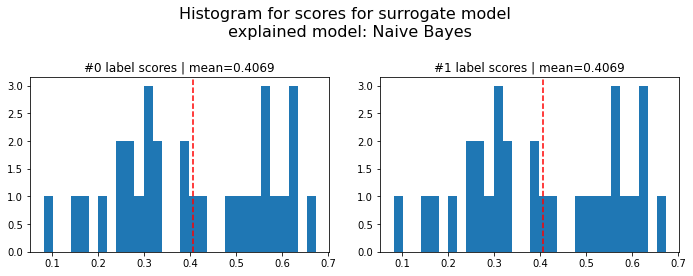

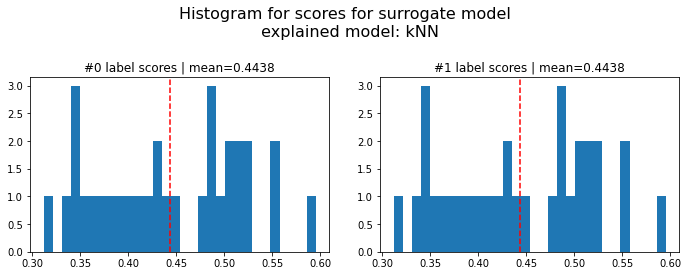

In [6]:
postprocessor_default.plot_scores_for_surrogate_model()

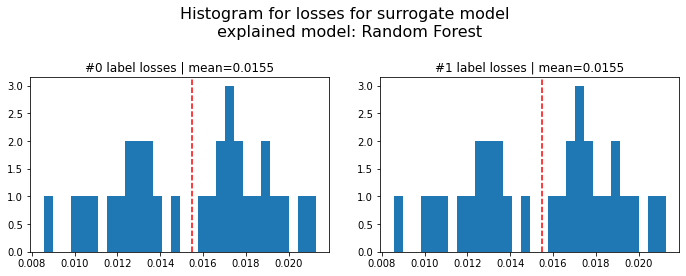

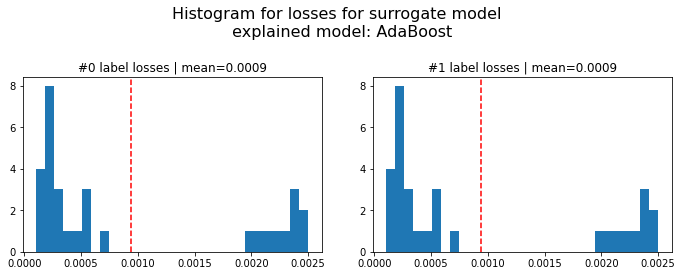

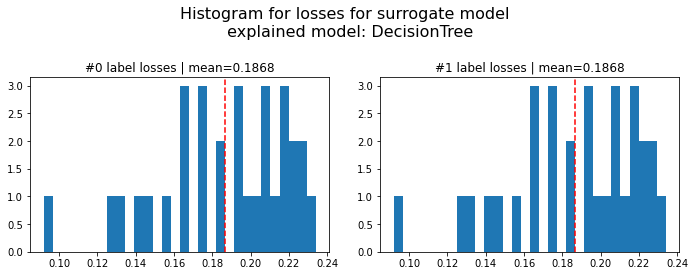

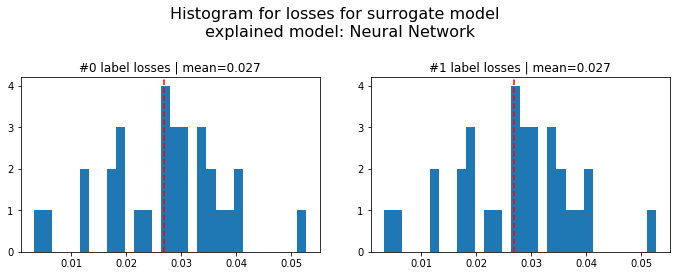

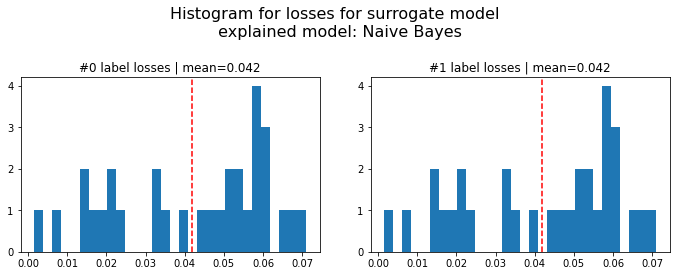

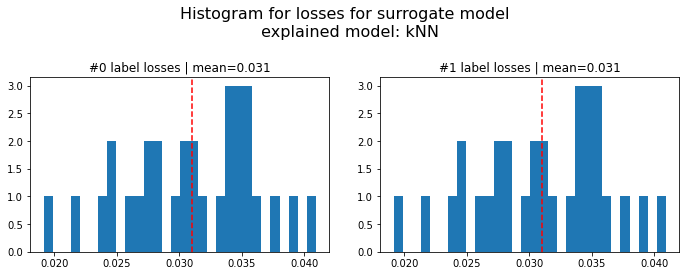

In [7]:
postprocessor_default.plot_losses_for_surrogate_model()

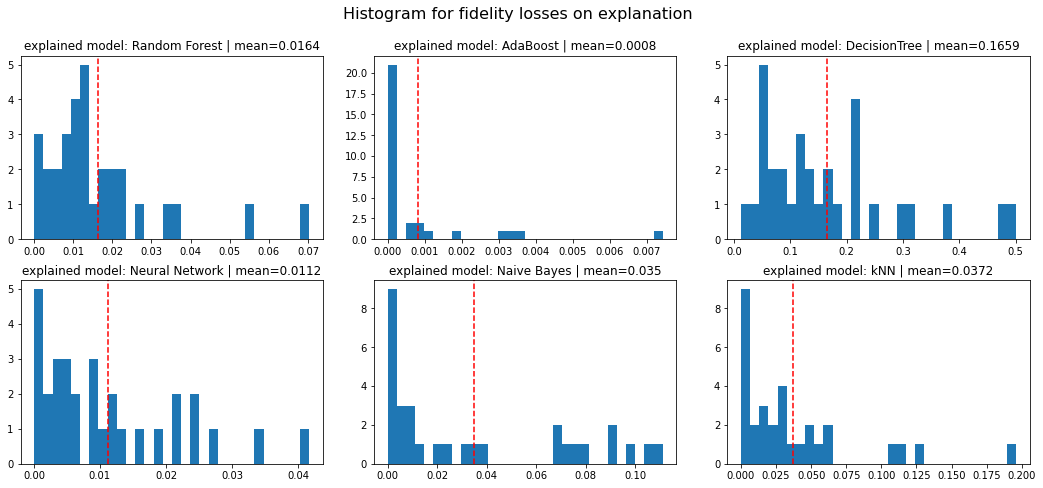

In [8]:
postprocessor_default.plot_fidelity_loss_on_explanation()

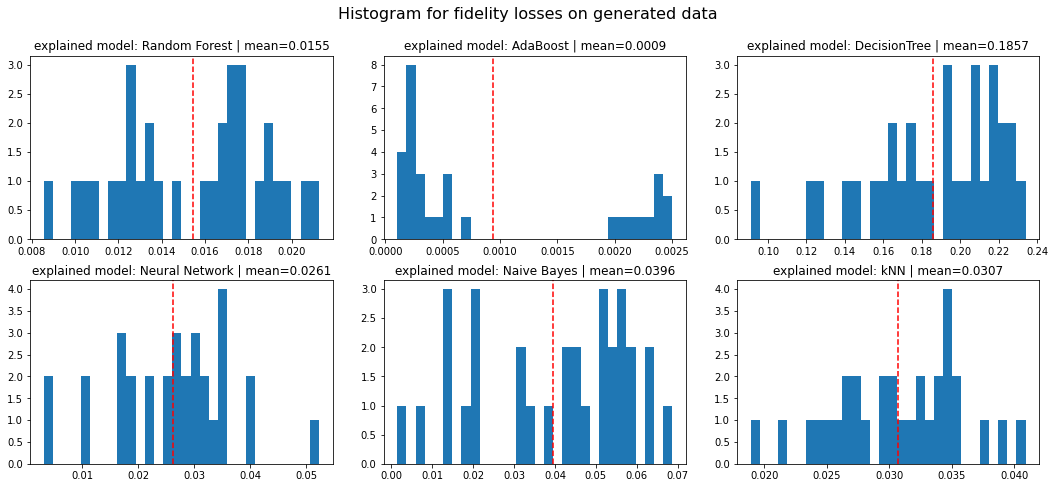

In [9]:
postprocessor_default.plot_fidelity_losses_on_generated_data()

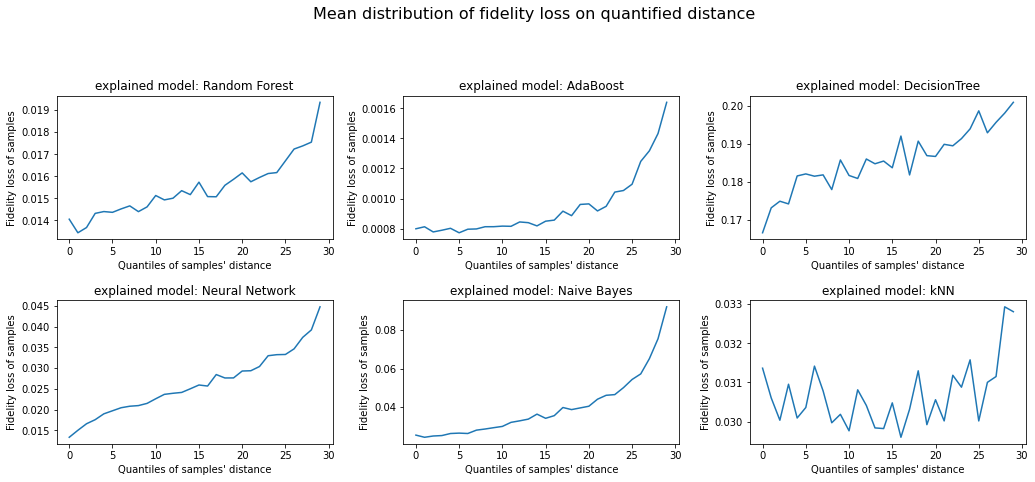

In [10]:
postprocessor_default.plot_fidelity_loss_distribution(domain_unit="Quantiles")





## Use modified LIME to explain classifiers' predictions





### Use multiple Regression Trees as local surrogate

In [11]:
results_file_multiregression = f"saved_results/{dataset_name}/multiregression_results_{version_str}"
if os.path.isfile(results_file_multiregression + ".npy"):
    postprocessor_multiregression = rp.ResultsProcessing.from_file(
        results_file_multiregression,
        models,
        labels_count
    )

else:
    scores_for_surrogate_model_multiregression = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    losses_for_surrogate_model_multiregression = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    losses_mean_for_cv_model_multiregression = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    losses_std_for_cv_model_multiregression = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    fidelity_loss_on_explanation_multiregression = \
        np.empty(shape=(len(models), test_instances_count,), dtype="float32")
    fidelity_loss_on_generated_data_multiregression = \
        np.empty(shape=(len(models), test_instances_count,), dtype="float32")
    fidelity_loss_distribution_quantiles_multiregression = \
        np.empty(shape=(len(models), test_instances_count, bins_count), dtype="float32")

    for model_idx, (classifier_name, model) in enumerate(models):

        explainer_multiregression = lime.lime_tabular_multiregressor.LTEMultiRegressionTree(
            dataset.train_data.to_numpy(),
            feature_names = dataset.train_data.columns.to_list(),
            class_names = model.classes_,
            discretize_continuous=False,
            sample_around_instance=True,
            categorical_features=dataset.categorical_features,
            with_kfold=5
        )

        for instance_idx, test_instance in enumerate(tqdm(
                    test_data_subset,
                    desc=f"{classifier_name}",
                    bar_format="{desc:<20}{percentage:3.0f}%|{bar}{r_bar}"
        )):

            explanation = explainer_multiregression.explain_instance(
                test_instance.reshape(-1),
                model.predict_proba,
                num_features = 4,
                top_labels = labels_count,
                distance_metric="minkowski",
                minkowski_norm=100.
            )
            scores_for_surrogate_model_multiregression[model_idx, instance_idx, :] = \
                explanation.get_scores_for_surrogate_model()
            losses_for_surrogate_model_multiregression[model_idx, instance_idx, :] = \
                explanation.get_losses_for_surrogate_model()
            losses_mean_for_cv_model_multiregression[model_idx, instance_idx, :] = \
                explanation.get_losses_for_cv_model(out="mean")
            losses_std_for_cv_model_multiregression[model_idx, instance_idx, :] = \
                explanation.get_losses_for_cv_model(out="std")
            fidelity_loss_on_explanation_multiregression[model_idx, instance_idx] = \
                explanation.get_fidelity_loss_on_explanation()
            fidelity_loss_on_generated_data_multiregression[model_idx, instance_idx] = \
                explanation.get_fidelity_loss_on_generated_data()
            fidelity_loss_distribution_quantiles_multiregression[model_idx, instance_idx, :] = \
                explanation.get_fidelity_loss_distribution(quantiles=bins_count)

    postprocessor_multiregression = rp.ResultsProcessing(
        models,
        labels_count,
        scores_for_surrogate_model_multiregression,
        losses_for_surrogate_model_multiregression,
        losses_mean_for_cv_model_multiregression,
        losses_std_for_cv_model_multiregression,
        fidelity_loss_on_explanation_multiregression,
        fidelity_loss_on_generated_data_multiregression,
        fidelity_loss_distribution_quantiles_multiregression
    )
    postprocessor_multiregression.save_results(results_file_multiregression)

kNN                 100%|██████████| 31/31 [00:39<00:00,  1.27s/it]


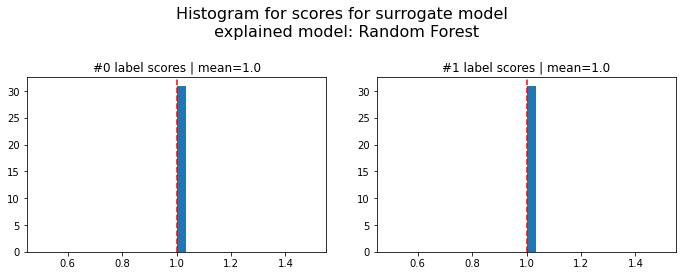

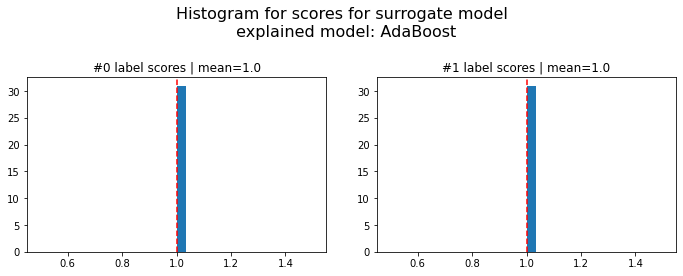

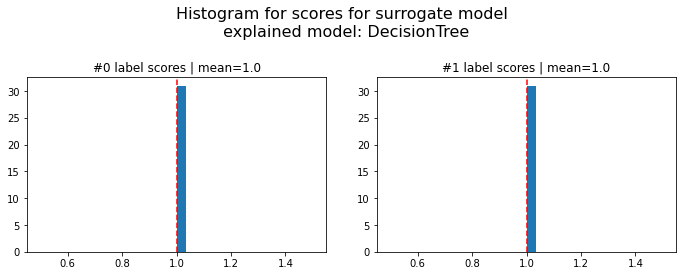

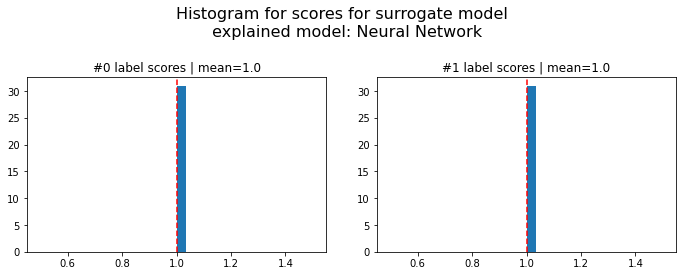

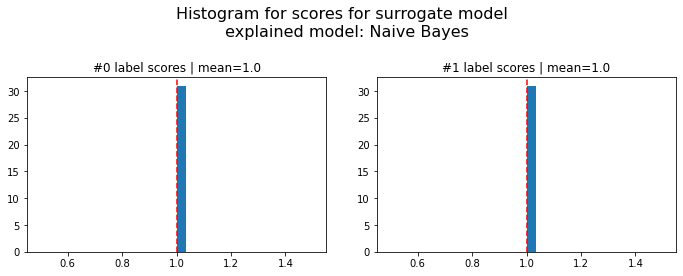

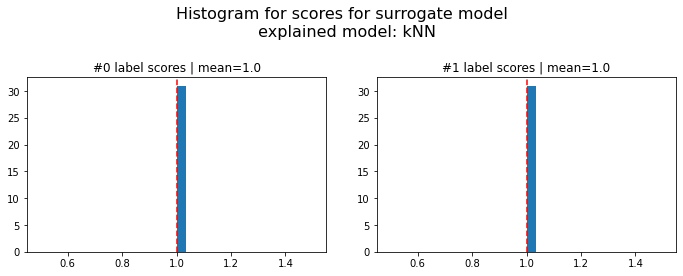

In [12]:
postprocessor_multiregression.plot_scores_for_surrogate_model()

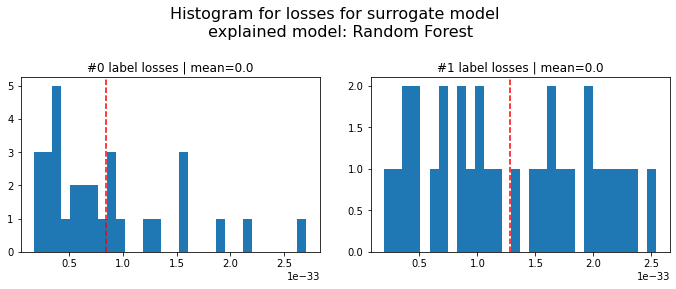

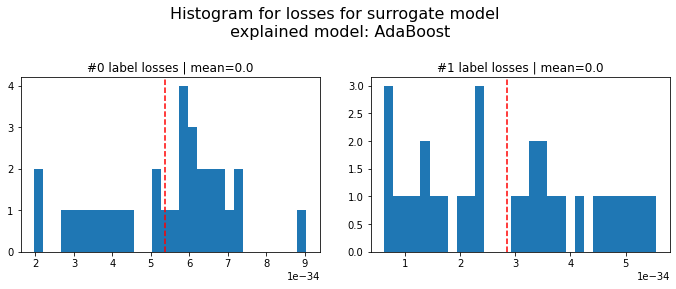

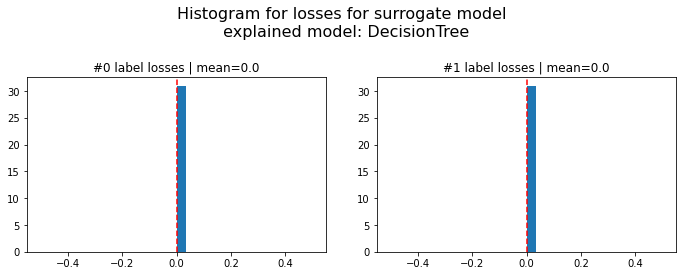

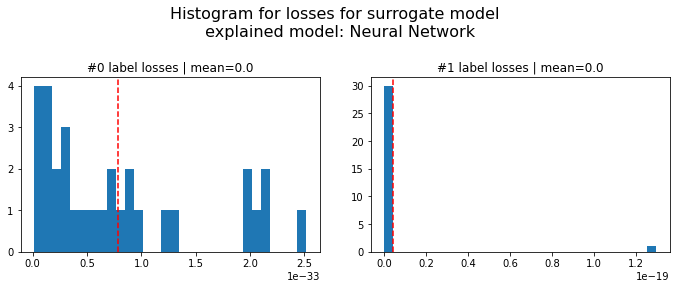

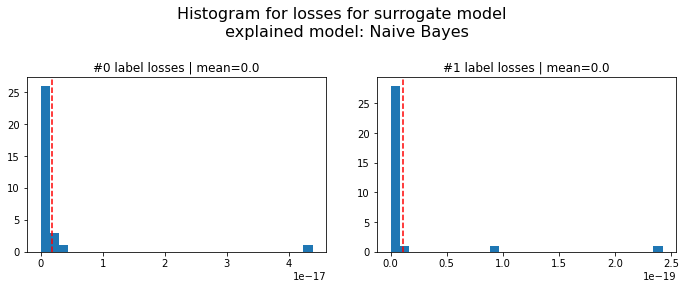

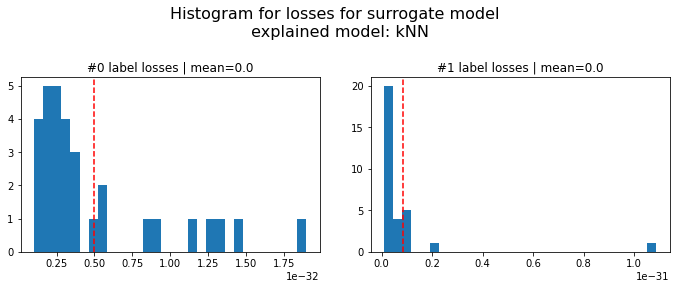

In [13]:
postprocessor_multiregression.plot_losses_for_surrogate_model()

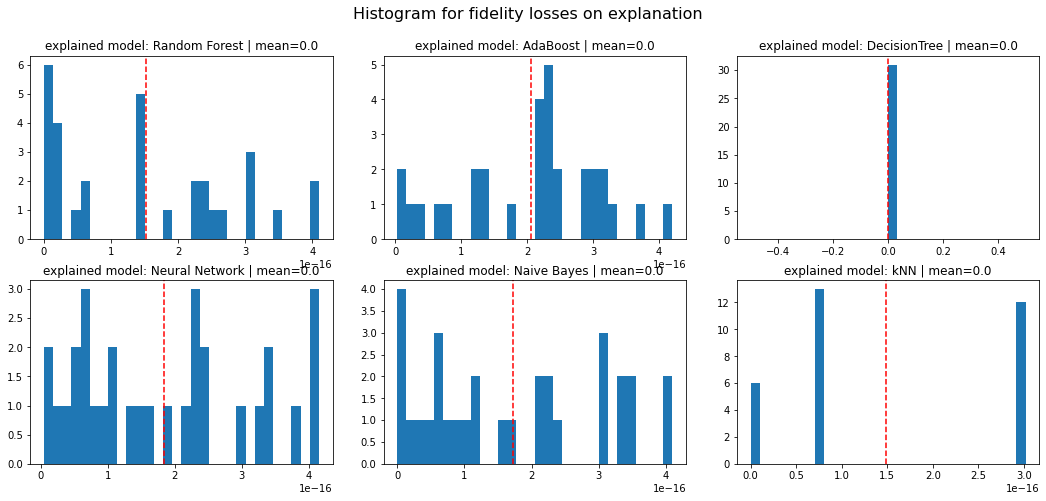

In [14]:
postprocessor_multiregression.plot_fidelity_loss_on_explanation()

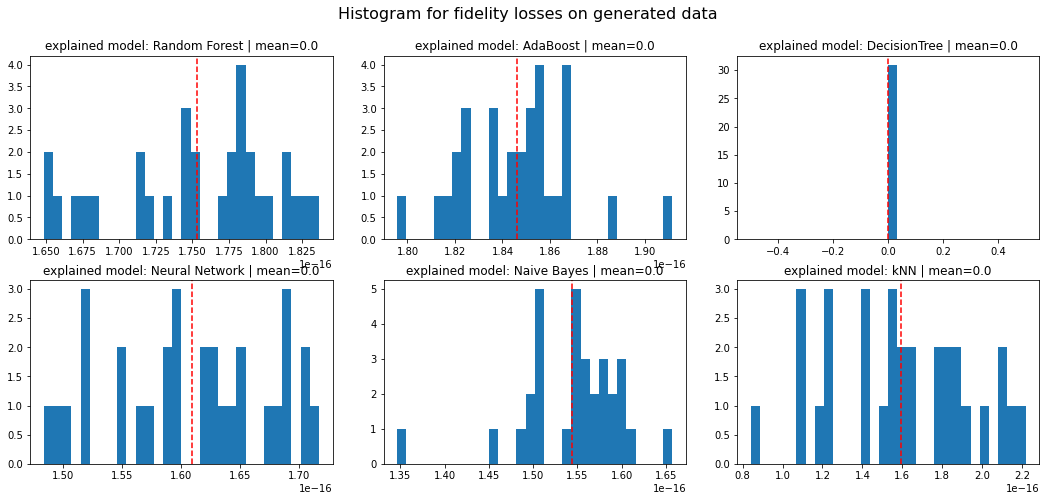

In [15]:
postprocessor_multiregression.plot_fidelity_losses_on_generated_data()

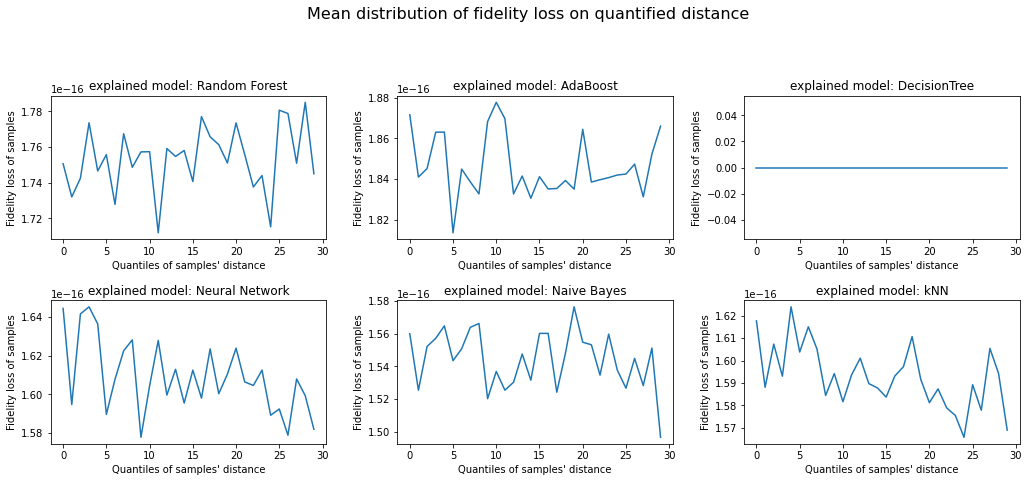

In [16]:
postprocessor_multiregression.plot_fidelity_loss_distribution(domain_unit="Quantiles")





### Use multiple Decision Trees as local surrogate

In [17]:
results_file_multiclassifier = f"saved_results/{dataset_name}/multiclassifier_results_{version_str}"
if os.path.isfile(results_file_multiclassifier + ".npy"):
    postprocessor_multiclassifier = rp.ResultsProcessing.from_file(
        results_file_multiclassifier,
        models,
        labels_count
    )

else:
    scores_for_surrogate_model_multiclassifier = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    losses_for_surrogate_model_multiclassifier = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    losses_mean_for_cv_model_multiclassifier = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    losses_std_for_cv_model_multiclassifier = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    fidelity_loss_on_explanation_multiclassifier = \
        np.empty(shape=(len(models), test_instances_count,), dtype="float32")
    fidelity_loss_on_generated_data_multiclassifier = \
        np.empty(shape=(len(models), test_instances_count,), dtype="float32")
    fidelity_loss_distribution_quantiles_multiclassifier = \
        np.empty(shape=(len(models), test_instances_count, bins_count), dtype="float32")

    for model_idx, (classifier_name, model) in enumerate(models):

        explainer_multiregression = lime.lime_tabular_multiclassifier.LTEMultiDecisionTree(
            dataset.train_data.to_numpy(),
            feature_names = dataset.train_data.columns.to_list(),
            class_names = model.classes_,
            discretize_continuous=False,
            sample_around_instance=True,
            categorical_features=dataset.categorical_features,
            with_kfold=5
        )

        for instance_idx, test_instance in enumerate(tqdm(
                    test_data_subset,
                    desc=f"{classifier_name}",
                    bar_format="{desc:<20}{percentage:3.0f}%|{bar}{r_bar}"
        )):

            explanation = explainer_multiregression.explain_instance(
                test_instance.reshape(-1),
                model.predict_proba,
                num_features = 4,
                top_labels = labels_count,
                distance_metric="minkowski",
                minkowski_norm=100.
            )
            scores_for_surrogate_model_multiclassifier[model_idx, instance_idx, :] = \
                explanation.get_scores_for_surrogate_model()
            losses_for_surrogate_model_multiclassifier[model_idx, instance_idx, :] = \
                explanation.get_losses_for_surrogate_model()
            losses_mean_for_cv_model_multiclassifier[model_idx, instance_idx, :] = \
                explanation.get_losses_for_cv_model(out="mean")
            losses_std_for_cv_model_multiclassifier[model_idx, instance_idx, :] = \
                explanation.get_losses_for_cv_model(out="std")
            fidelity_loss_on_explanation_multiclassifier[model_idx, instance_idx] = \
                explanation.get_fidelity_loss_on_explanation()
            fidelity_loss_on_generated_data_multiclassifier[model_idx, instance_idx] = \
                explanation.get_fidelity_loss_on_generated_data()
            fidelity_loss_distribution_quantiles_multiclassifier[model_idx, instance_idx, :] = \
                explanation.get_fidelity_loss_distribution(quantiles=bins_count)

    postprocessor_multiclassifier = rp.ResultsProcessing(
        models,
        labels_count,
        scores_for_surrogate_model_multiclassifier,
        losses_for_surrogate_model_multiclassifier,
        losses_mean_for_cv_model_multiclassifier,
        losses_std_for_cv_model_multiclassifier,
        fidelity_loss_on_explanation_multiclassifier,
        fidelity_loss_on_generated_data_multiclassifier,
        fidelity_loss_distribution_quantiles_multiclassifier
    )
    postprocessor_multiclassifier.save_results(results_file_multiclassifier)

kNN                 100%|██████████| 31/31 [00:31<00:00,  1.00s/it]


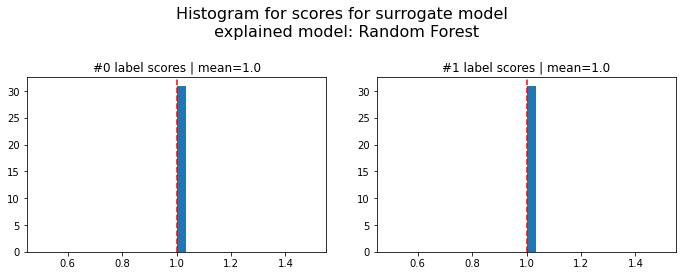

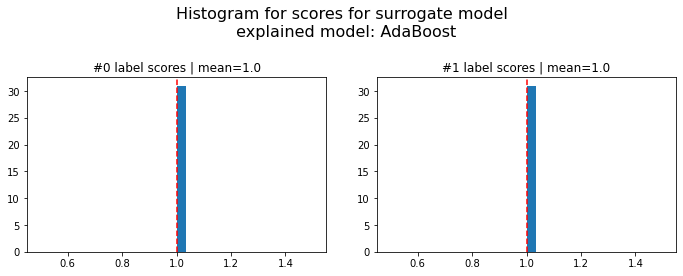

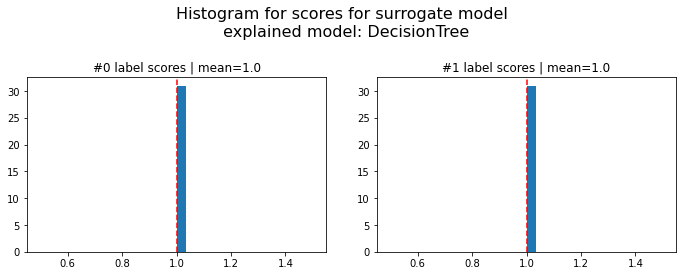

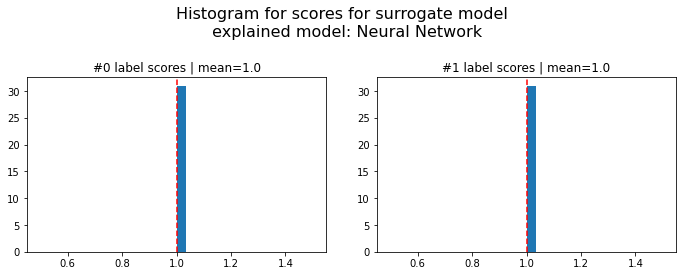

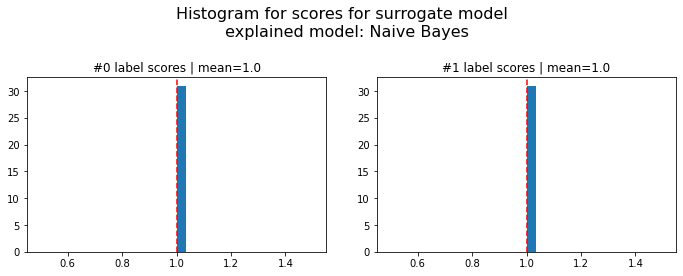

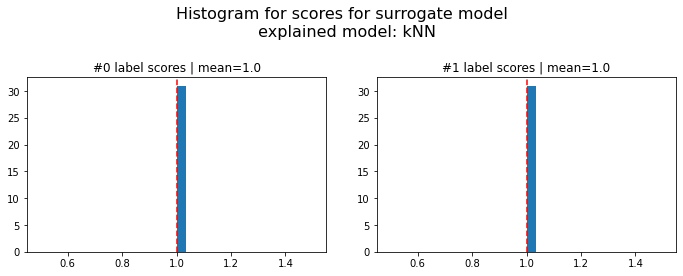

In [18]:
postprocessor_multiclassifier.plot_scores_for_surrogate_model()

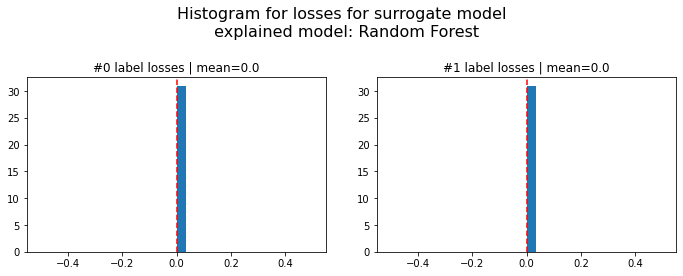

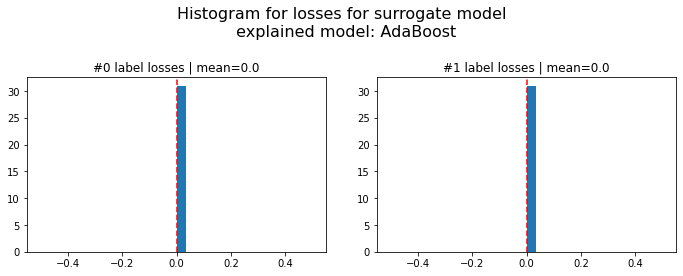

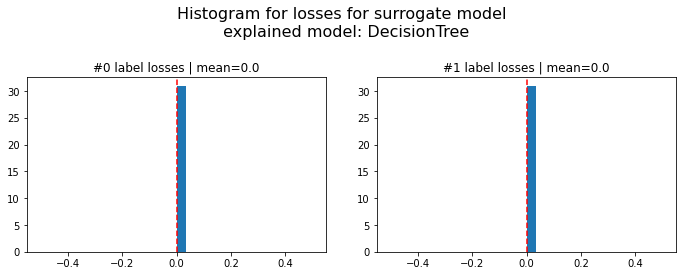

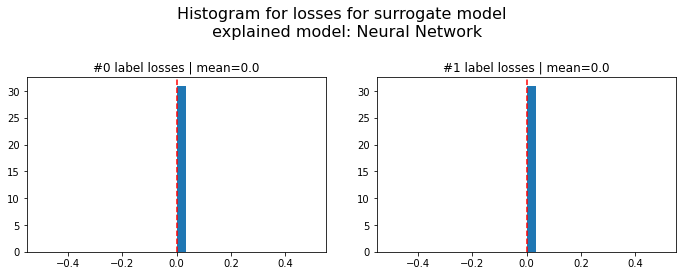

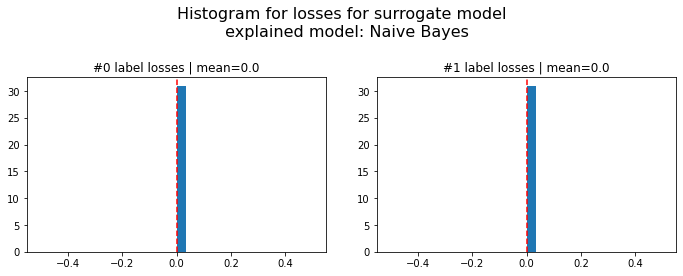

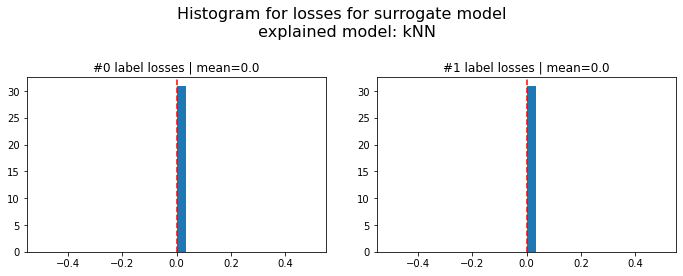

In [19]:
postprocessor_multiclassifier.plot_losses_for_surrogate_model()

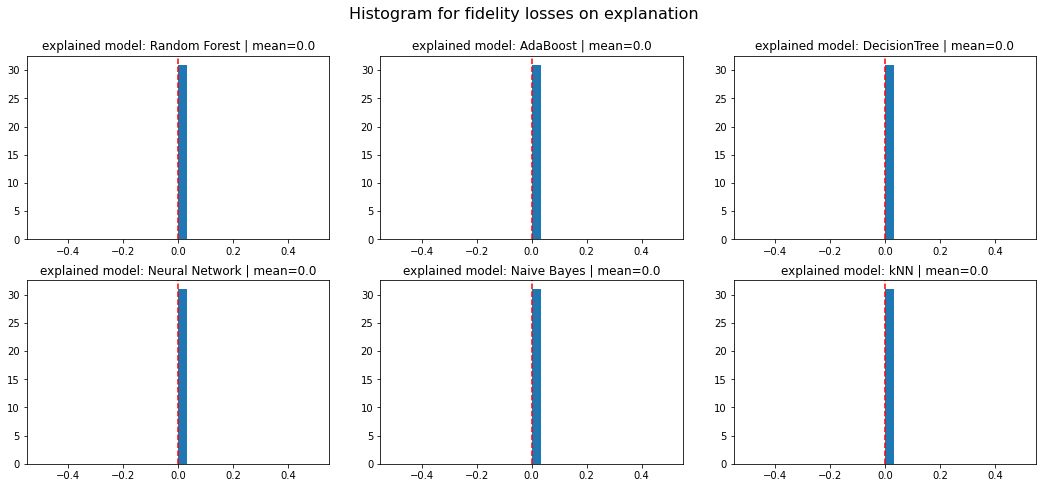

In [20]:
postprocessor_multiclassifier.plot_fidelity_loss_on_explanation()

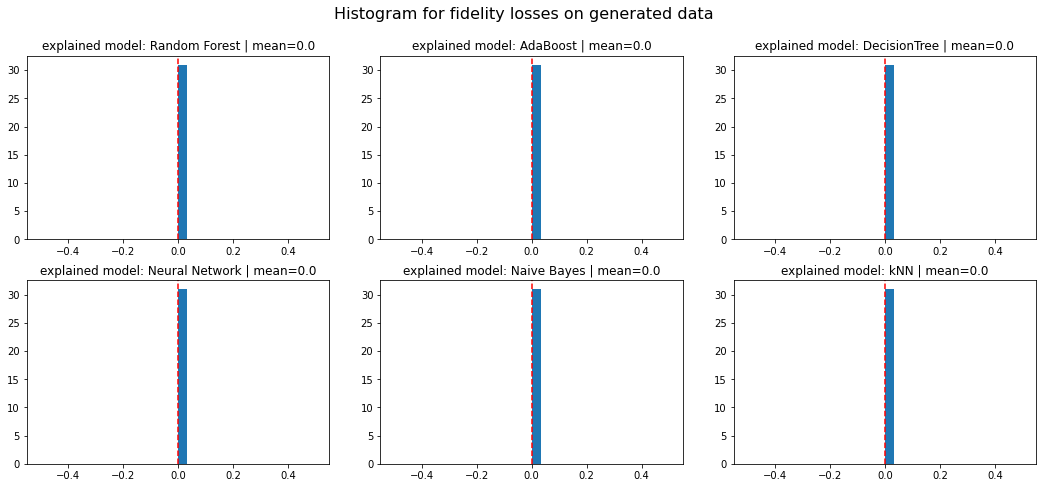

In [21]:
postprocessor_multiclassifier.plot_fidelity_losses_on_generated_data()

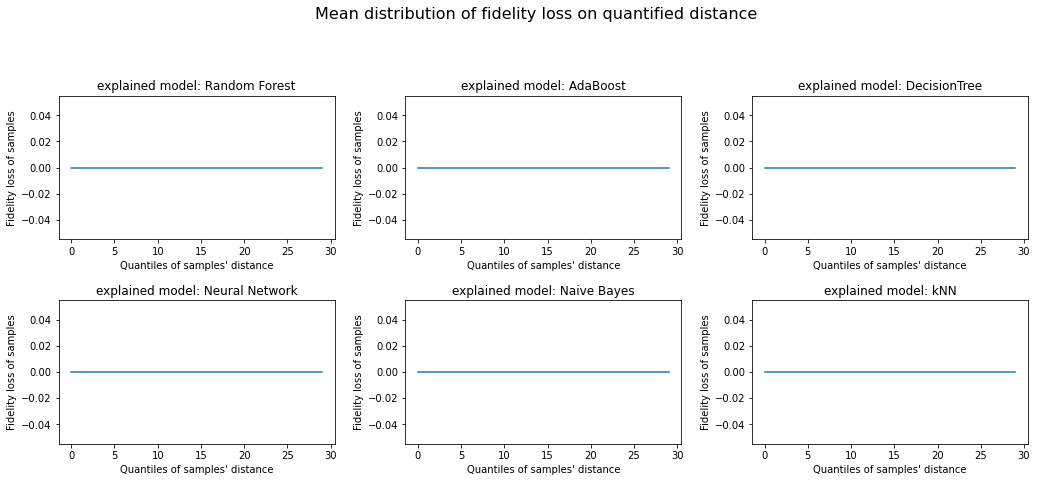

In [22]:
postprocessor_multiclassifier.plot_fidelity_loss_distribution(domain_unit="Quantiles")





### Use single Decision Tree as local surrogate

In [ ]:
results_file_singleclassifier = f"saved_results/{dataset_name}/singleclassifier_results_{version_str}"
if os.path.isfile(results_file_singleclassifier + ".npy"):
    postprocessor_singleclassifier = rp.ResultsProcessing.from_file(
        results_file_singleclassifier,
        models,
        labels_count
    )

else:
    scores_for_surrogate_model_singleclassifier = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    losses_for_surrogate_model_singleclassifier = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    losses_mean_for_cv_model_singleclassifier = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    losses_std_for_cv_model_singleclassifier = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    fidelity_loss_on_explanation_singleclassifier = \
        np.empty(shape=(len(models), test_instances_count,), dtype="float32")
    fidelity_loss_on_generated_data_singleclassifier = \
        np.empty(shape=(len(models), test_instances_count,), dtype="float32")
    fidelity_loss_distribution_quantiles_singleclassifier = \
        np.empty(shape=(len(models), test_instances_count, bins_count), dtype="float32")

    for model_idx, (classifier_name, model) in enumerate(models):

        explainer_multiregression = lime.lime_tabular_singleclassifier.LTESingleDecisionTree(
            dataset.train_data.to_numpy(),
            feature_names = dataset.train_data.columns.to_list(),
            class_names = model.classes_,
            discretize_continuous=False,
            sample_around_instance=True,
            categorical_features=dataset.categorical_features,
            with_kfold=5
        )

        for instance_idx, test_instance in enumerate(tqdm(
                    test_data_subset,
                    desc=f"{classifier_name}",
                    bar_format="{desc:<20}{percentage:3.0f}%|{bar}{r_bar}"
        )):

            explanation = explainer_multiregression.explain_instance(
                test_instance.reshape(-1),
                model.predict_proba,
                num_features = 4,
                top_labels = labels_count,
                distance_metric="minkowski",
                minkowski_norm=100.
            )
            scores_for_surrogate_model_singleclassifier[model_idx, instance_idx, :] = \
                explanation.get_scores_for_surrogate_model()
            losses_for_surrogate_model_singleclassifier[model_idx, instance_idx, :] = \
                explanation.get_losses_for_surrogate_model()
            losses_mean_for_cv_model_singleclassifier[model_idx, instance_idx, :] = \
                explanation.get_losses_for_cv_model(out="mean")
            losses_std_for_cv_model_singleclassifier[model_idx, instance_idx, :] = \
                explanation.get_losses_for_cv_model(out="std")
            fidelity_loss_on_explanation_singleclassifier[model_idx, instance_idx] = \
                explanation.get_fidelity_loss_on_explanation()
            fidelity_loss_on_generated_data_singleclassifier[model_idx, instance_idx] = \
                explanation.get_fidelity_loss_on_generated_data()
            fidelity_loss_distribution_quantiles_singleclassifier[model_idx, instance_idx, :] = \
                explanation.get_fidelity_loss_distribution(quantiles=bins_count)

    postprocessor_singleclassifier = rp.ResultsProcessing(
        models,
        labels_count,
        scores_for_surrogate_model_singleclassifier,
        losses_for_surrogate_model_singleclassifier,
        losses_mean_for_cv_model_singleclassifier,
        losses_std_for_cv_model_singleclassifier,
        fidelity_loss_on_explanation_singleclassifier,
        fidelity_loss_on_generated_data_singleclassifier,
        fidelity_loss_distribution_quantiles_singleclassifier
    )
    postprocessor_singleclassifier.save_results(results_file_singleclassifier)

Neural Network       84%|████████▍ | 26/31 [00:23<00:04,  1.05it/s]

In [ ]:
postprocessor_singleclassifier.plot_scores_for_surrogate_model()

In [ ]:
postprocessor_singleclassifier.plot_losses_for_surrogate_model()

In [ ]:
postprocessor_singleclassifier.plot_fidelity_loss_on_explanation()

In [ ]:
postprocessor_singleclassifier.plot_fidelity_losses_on_generated_data()

In [ ]:
postprocessor_singleclassifier.plot_fidelity_loss_distribution(domain_unit="Quantiles")
